In [1]:
#Convolutional Neural Network with MNIST
from IPython.display import display, Image
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

In [2]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [3]:
#define data dimensions
input_dim_model=(1,28,28) #Images are 28x28 with 1 channel of color (gray)
input_dim=28*28 #used by readers to treat the input data as vector
num_output_classes=10

In [4]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):

    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))

    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [5]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:

    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")

    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break

if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")

print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [6]:
#Convolution Layer
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

In [7]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'With stride = 2'),
          ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'With stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

With stride = 2


With stride = 1


In [8]:
#CNN Model Creation
x=C.input_variable(input_dim_model)
y=C.input_variable(num_output_classes)

In [9]:
#Function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
        h=features
        h=C.layers.Convolution2D(filter_shape=(5,5),
                                num_filters=8,
                                strides=(2,2),
                                pad=True, name='first_conv')(h)
        h=C.layers.Convolution2D(filter_shape=(5,5),
                                num_filters=16,
                                strides=(2,2),
                                pad=True, name='second_conv')(h)
        r=C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
        return r
    

In [10]:
#Create the model
z=create_model(x)

#print the output shape/ parameter of different components 
print("Output shape of first Convolution Layer: ", z.first_conv.shape)
print("Bias value of the last Dense Layer: ", z.classify.b.value)

Output shape of first Convolution Layer:  (8, 14, 14)
Bias value of the last Dense Layer:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
#Number of parameters in this network
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


In [12]:
#Training
def create_criterion_function(model, labels):
    loss=C.cross_entropy_with_softmax(model, labels)
    errs=C.classification_error(model, labels)
    return loss, errs #(model) -> (loss, error metric)

In [13]:
#Define a utility function to compute the moving average sum
#A more efficient implementation is possible with np.cumsum function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

#Define a utility that defines a training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss="NA"
    eval_error="NA"
    
    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))

    return mb, training_loss, eval_error

In [14]:
#Configure Training
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    #Instantiate the model function; x is the input feature
    #We will scale the input image pixels with the range of 0-1 by dividing it with 255
    model=model_func(x/255)
    
    #Instantiate the loss and error function
    loss, label_error=create_criterion_function(model, y)
    
    #Instantiate the trainer object to drive the model training
    learning_rate=0.2
    lr_schedule=C.learning_parameter_schedule(learning_rate)
    learner=C.sgd(z.parameters, lr_schedule)
    trainer=C.Trainer(z, (loss, label_error), [learner])
    
    #Initialize the parameters for the trainer
    minibatch_size=64
    num_samples_per_sweep=60000
    num_minibatches_to_train=(num_samples_per_sweep*num_sweeps_to_train_with)/minibatch_size
    
    #Map the data streams to the input and labels
    input_map={
        y: train_reader.streams.labels,
        x: train_reader.streams.features
    }
    
    training_progress_output_freq=500
    
    #start timer 
    start=time.time()
    
    for i in range(0, int(num_minibatches_to_train)):
        #Read a minibatch form a training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map)
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
        
    #Print training time
    print("Training took {:.1f} sec".format(time.time()-start))
    
    #test the model
    test_input_map={
        y: test_reader.streams.labels,
        x: test_reader.streams.features
    }
    
    #Test data for trained model
    test_minibatch_size=512
    num_samples=10000
    num_minibatches_to_test=num_samples//test_minibatch_size
    
    test_result=0.0
    
    for i in range(num_minibatches_to_test):
        
        #We are loading test data in batches specified by test_minibatch_size
        #Each datapoint in the minibatch is a MNIST digit image of 784 dimensions
        #with one pixel per dimension which will encode/decode with the trained model
        data=test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error=trainer.test_minibatch(data)
        test_result=test_result+eval_error
    
    #Average of evaluation errors of all test minibatches
    print("Average test error: {:.2f}%".format(test_result*100/num_minibatches_to_test))
        

In [15]:
#Run the Trainer and Test Model
def do_train_test():
    global z
    z= create_model(x)
    reader_train= create_reader(train_file, True, input_dim, num_output_classes)
    reader_test= create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
    
    
do_train_test()

Minibatch: 0, Loss: 2.3093, Error: 89.06%
Minibatch: 500, Loss: 0.2081, Error: 7.81%
Minibatch: 1000, Loss: 0.1345, Error: 4.69%
Minibatch: 1500, Loss: 0.1095, Error: 3.12%
Minibatch: 2000, Loss: 0.0259, Error: 0.00%
Minibatch: 2500, Loss: 0.0036, Error: 0.00%
Minibatch: 3000, Loss: 0.0094, Error: 0.00%
Minibatch: 3500, Loss: 0.0484, Error: 1.56%
Minibatch: 4000, Loss: 0.0214, Error: 0.00%
Minibatch: 4500, Loss: 0.0403, Error: 1.56%
Minibatch: 5000, Loss: 0.0155, Error: 1.56%
Minibatch: 5500, Loss: 0.0020, Error: 0.00%
Minibatch: 6000, Loss: 0.0126, Error: 0.00%
Minibatch: 6500, Loss: 0.0167, Error: 0.00%
Minibatch: 7000, Loss: 0.0207, Error: 1.56%
Minibatch: 7500, Loss: 0.0021, Error: 0.00%
Minibatch: 8000, Loss: 0.0024, Error: 0.00%
Minibatch: 8500, Loss: 0.0174, Error: 0.00%
Minibatch: 9000, Loss: 0.0313, Error: 1.56%
Training took 102.4 sec
Average test error: 1.46%


In [16]:
print("Bias value of the last dense layer: ", z.classify.b.value) #It must be non-zero as it is updating. Previously it was set to 
#zero before running the model

Bias value of the last dense layer:  [-0.02137667 -0.05231637  0.0724031  -0.07259671 -0.02112111 -0.06834911
 -0.00605507 -0.12185648  0.25030175  0.04093128]


In [17]:
#Run evaluation/Prediction
out= C.softmax(z)

In [18]:
#Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size=25
eval_input_map= {
    x: reader_eval.streams.features, 
    y: reader_eval.streams.labels
}

data=reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label=data[y].asarray()
img_data=data[x].asarray()

#Reshape the img_data to M x 1 x 28 x 28 to be comaptible with the model
img_data=np.reshape(img_data, (eval_minibatch_size, 1,28,28))

predicted_label_prob=[out.eval(img_data[i]) for i in range(len(img_data))]

In [19]:
#Find the index with maximum value for the predicted as well as the ground truth
pred= [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel=[np.argmax(img_label[i]) for i in range(len(img_label))]

In [20]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


Image Label: 4


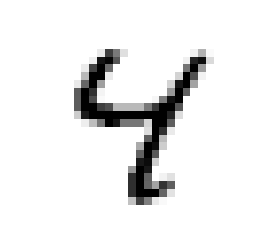

In [21]:
#Plot a random image
sample_number=6
plt.imshow(img_data[sample_number].reshape(28, 28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred= gtlabel[sample_number], pred[sample_number]
print("Image Label:", img_pred )

In [22]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=300, height=300))

Max pooling


Average pooling


In [25]:
#Create a network with MaxPooling

#Modify the model
def create_model(features):
    with C.layers.default_options(init=C.layers.glorot_uniform(), activation=C.relu):
        h=features
        h=C.layers.Convolution2D(filter_shape=(5,5),
                                num_filters=8,
                                strides=(1,1),
                                pad=True,
                                name="first_conv")(h)
        h=C.layers.MaxPooling(filter_shape=(2,2),
                            strides=(2,2),
                            name="first_max")(h)
        h=C.layers.Convolution2D(filter_shape=(5,5),
                                num_filters=16,
                                strides=(1,1),
                                pad=True,
                                name="second_conv")(h)
        h=C.layers.MaxPooling(filter_shape=(3,3),
                             strides=(3,3),
                             name="second_max")(h)
        r=C.layers.Dense(num_output_classes, activation=None, name="classify")(h)
        return r
    
do_train_test()
    

Minibatch: 0, Loss: 2.3725, Error: 89.06%
Minibatch: 500, Loss: 0.1950, Error: 10.94%
Minibatch: 1000, Loss: 0.1154, Error: 1.56%
Minibatch: 1500, Loss: 0.0428, Error: 1.56%
Minibatch: 2000, Loss: 0.0143, Error: 0.00%
Minibatch: 2500, Loss: 0.0266, Error: 1.56%
Minibatch: 3000, Loss: 0.0102, Error: 0.00%
Minibatch: 3500, Loss: 0.0530, Error: 1.56%
Minibatch: 4000, Loss: 0.0093, Error: 0.00%
Minibatch: 4500, Loss: 0.0387, Error: 1.56%
Minibatch: 5000, Loss: 0.0337, Error: 1.56%
Minibatch: 5500, Loss: 0.0019, Error: 0.00%
Minibatch: 6000, Loss: 0.0086, Error: 0.00%
Minibatch: 6500, Loss: 0.0094, Error: 0.00%
Minibatch: 7000, Loss: 0.0191, Error: 0.00%
Minibatch: 7500, Loss: 0.0063, Error: 0.00%
Minibatch: 8000, Loss: 0.0013, Error: 0.00%
Minibatch: 8500, Loss: 0.0138, Error: 0.00%
Minibatch: 9000, Loss: 0.0259, Error: 3.12%
Training took 84.6 sec
Average test error: 1.09%
